In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Model, GPT2LMHeadModel
import imageio, os
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

run_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# model settings
RESOLUTION_WIDTH = 128
RESOLUTION_HEIGHT = 128
CHANNELS = 3
BOTTLENECK_DIM = 768

In [3]:
class ImageProcessor:
    def tensor_to_pil(self, image_tensor: torch.Tensor) -> Image.Image:
        """
        Convert a tensor to a PIL Image.
        
        Args:
            image_tensor (torch.Tensor): A tensor of shape (C, H, W) with pixel values in the range [0, 1].
        
        Returns:
            Image.Image: A PIL Image object.
        """
        # Clamp to [0, 1], convert to [0, 255] and uint8
        image_np = (image_tensor.clamp(0, 1).mul(255).byte().cpu().permute(1, 2, 0).numpy())
        return Image.fromarray(image_np)
    
    def pil_to_tensor(self, image: Image.Image) -> torch.Tensor:
        """
        Convert a PIL image to a PyTorch tensor of shape (C, H, W) with values in [0, 1].
        
        Args:
            image (Image.Image): A PIL Image object.
        
        Returns:
            torch.Tensor: A tensor of shape (C, H, W) with pixel values in the range [0, 1].
        """
        return transforms.ToTensor()(image)  # Already returns (C, H, W)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, 1, 1)
        )
    def forward(self, x):
        return x + self.block(x)

class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=CHANNELS, latent_dim=BOTTLENECK_DIM, input_resolution=(RESOLUTION_WIDTH, RESOLUTION_HEIGHT)):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),           # 32x32
            nn.ReLU(),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 4, 2, 1),          # 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),         # 8x8
            nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, *input_resolution)
            enc_out = self.encoder(dummy)
            self.flattened_size = enc_out.view(1, -1).shape[1]

        self.encoder_fc = nn.Linear(self.flattened_size, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, enc_out.shape[1:]),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.ReLU(),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1),  # 128x128
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        return self.encoder_fc(x)

    def decode(self, z):
        z = self.decoder_fc(z)
        return self.decoder(z)

In [6]:
# Load the autoencoder
autoenc = ConvAutoencoder()
state_dict = torch.load("checkpoints/run11/autoenc.pth", map_location=run_device)
autoenc.load_state_dict(state_dict)
autoenc = autoenc.to(run_device).eval()

# Load the base model first
transformer = GPT2LMHeadModel.from_pretrained("checkpoints/run11/gpt2_decap")
transformer = transformer.to(run_device).eval()

# Load image processor
proc = ImageProcessor()

OSError: Error no file named pytorch_model.bin, tf_model.h5, model.ckpt.index or flax_model.msgpack found in directory checkpoints/run11/gpt2_decap.

In [ ]:
def generate_frames(num_frames, context_length=32, initial_image_tensor=None, initial_image_count=16, autoenc=autoenc, transformer=transformer):
    with torch.no_grad():
        # sequence of frames, stored as a list to avoid repeated tensor cat / realloc
        seq = []

        if initial_image_tensor is not None:
            # replicate initial image to form the seed context
            initial_images = initial_image_tensor.unsqueeze(0).repeat((initial_image_count, 1, 1, 1))
            seq.extend(initial_images)

        # collect only the output (predicted) frames for video writing
        output_frames = []

        for _ in tqdm(range(num_frames)):
            # get the last `context_length` frames as a context window
            context = torch.stack(seq[-context_length:])  # shape: (context_length, C, H, W)

            # encode the context window into latent space
            latents = autoenc.encode(context)  # shape: (context_length, bottleneck_dim)

            # predict next latent using transformer, needs batch/time dim
            pred_latents = transformer(inputs_embeds=latents.unsqueeze(0)).last_hidden_state  # shape: (1, context_length, bottleneck_dim)

            # get only the predicted next latent (last in the sequence)
            next_latent = pred_latents[0, -1]  # shape: (bottleneck_dim,)

            # decode the latent back into an image
            next_frame = autoenc.decode(next_latent.unsqueeze(0))  # shape: (1, C, H, W)

            # store the predicted frame for context and output
            seq.append(next_frame.squeeze(0))  # context sequence
            output_frames.append(next_frame.squeeze(0).detach().cpu())  # save output on CPU

        # return full sequence of output frames
        return torch.stack(output_frames)


In [ ]:
def save_video(frames, output='output.mp4', fps=60):
    writer = imageio.get_writer(output, fps=fps)
    for frame in tqdm(frames):
        img = frame.permute(1,2,0).numpy()
        img = ((img + 1)/2 * 255).astype('uint8')
        writer.append_data(img)
    writer.close()
    print(f'Saved {output}')

In [ ]:
init_img = proc.pil_to_tensor(Image.open("test.png").convert('RGB').resize((RESOLUTION_WIDTH, RESOLUTION_HEIGHT))).to(run_device)

frames = generate_frames(1200, initial_image_tensor=init_img).detach().cpu()
torch.cuda.empty_cache()
save_video(frames)

100%|██████████| 1200/1200 [00:00<00:00, 1334.03it/s]

Saved output.mp4


In [ ]:
frames.shape

torch.Size([1200, 3, 128, 128])

In [ ]:
img = Image.open("test.png").convert('RGB').resize((RESOLUTION_WIDTH, RESOLUTION_HEIGHT))

In [ ]:
enc_img = proc.pil_to_tensor(img).to(run_device).unsqueeze(0)

In [ ]:
latent = autoenc.encode(enc_img)

In [ ]:
prediction = transformer(inputs_embeds=latent).last_hidden_state

In [ ]:
decoded = autoenc.decode(prediction)

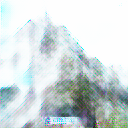

In [ ]:
proc.tensor_to_pil(decoded.squeeze(0))